In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader, TensorDataset
from itertools import chain


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

news = pd.read_csv("/content/drive/MyDrive/prj/OnlineNewsPopularity.csv")


desired_columns = [' timedelta', ' n_tokens_title', ' n_tokens_content',
                   ' n_unique_tokens', ' num_hrefs', ' num_self_hrefs', ' num_imgs',
                   ' num_videos', ' average_token_length', ' num_keywords',
                   ' data_channel_is_lifestyle', ' data_channel_is_entertainment',
                   ' data_channel_is_bus', ' data_channel_is_socmed', ' data_channel_is_tech',
                   ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
                   ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg', ' kw_max_avg',
                   ' kw_avg_avg', ' self_reference_min_shares', ' self_reference_max_shares',
                   ' self_reference_avg_sharess', ' weekday_is_monday', ' weekday_is_tuesday',
                   ' weekday_is_wednesday', ' weekday_is_thursday', ' weekday_is_friday',
                   ' weekday_is_saturday', ' weekday_is_sunday', ' is_weekend', ' LDA_00',
                   ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04', ' global_subjectivity',
                   ' global_sentiment_polarity', ' global_rate_positive_words',
                   ' global_rate_negative_words', ' rate_positive_words',
                   ' rate_negative_words', ' avg_positive_polarity', ' min_positive_polarity',
                   ' max_positive_polarity', ' avg_negative_polarity', ' min_negative_polarity',
                   ' max_negative_polarity', ' title_subjectivity', ' title_sentiment_polarity',
                   ' abs_title_subjectivity', ' abs_title_sentiment_polarity', ' shares']

new_news = news[desired_columns]


new_news.columns = new_news.columns.str.strip()


threshold = 150000
fltr_new_news = new_news[new_news['shares'] <= threshold]


predictors = fltr_new_news.drop(['shares'], axis=1)
target = fltr_new_news['shares']


target = (target > 1400).astype(int)


predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.3, random_state=1)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(predictors_train)
X_test_scaled = scaler.transform(predictors_test)

# connvert data into tensor usong pytorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(target_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(target_test.values, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Feed forward neural network

In [ ]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
# Training Loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs):
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate loss
            loss_train += loss.item()

        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {loss_train / len(train_loader):.4f}")


def test(model, train_loader, test_loader, num_classes):
    model.eval()
    predict_train, predict_test = [], []
    labels_train, labels_test = [], []

    with torch.no_grad():

        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_train.append(predicted.tolist())
            labels_train.append(labels.tolist())


        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_test.append(predicted.tolist())
            labels_test.append(labels.tolist())


        print("Confusion Matrix (Train):")
        print(confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=list(range(num_classes))))
        print("\nClassification Report (Train):")
        print(classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=list(range(num_classes))))


        print("\nConfusion Matrix (Test):")
        print(confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=list(range(num_classes))))
        print("\nClassification Report (Test):")
        print(classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=list(range(num_classes))))


In [ ]:

input_size = X_train_tensor.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2
torch.manual_seed(42)
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()

# Train the model
training_loop(n_epochs=10, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)


Epoch 1/10, Training Loss: 0.6571
Epoch 2/10, Training Loss: 0.6313
Epoch 3/10, Training Loss: 0.6243
Epoch 4/10, Training Loss: 0.6194
Epoch 5/10, Training Loss: 0.6156
Epoch 6/10, Training Loss: 0.6123
Epoch 7/10, Training Loss: 0.6097
Epoch 8/10, Training Loss: 0.6071
Epoch 9/10, Training Loss: 0.6046
Epoch 10/10, Training Loss: 0.6026


In [ ]:

test(model, train_loader, test_loader, num_classes=output_size)


Confusion Matrix (Train):
[[9483 4500]
 [4545 9206]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.68      0.68      0.68     13983
           1       0.67      0.67      0.67     13751

    accuracy                           0.67     27734
   macro avg       0.67      0.67      0.67     27734
weighted avg       0.67      0.67      0.67     27734


Confusion Matrix (Test):
[[4047 2052]
 [1919 3869]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      6099
           1       0.65      0.67      0.66      5788

    accuracy                           0.67     11887
   macro avg       0.67      0.67      0.67     11887
weighted avg       0.67      0.67      0.67     11887



# Tuning

In [ ]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report

# Parameters
batch_sizes = [16, 32, 64, 128]
learning_rates = [0.1, 0.01, 0.001, 0.0001]
hidden_layer_configs = [256, 128, 64]
activation_functions = [nn.ReLU(), nn.Tanh(), nn.Sigmoid()]
layers_no = [1, 2, 3]
optimizers = [('Adam', optim.Adam), ('SGD', optim.SGD), ('RMSprop', optim.RMSprop)]
n_iterations = 16  # Number of random combinations to test
best_accuracy = 0
best_params = {}

# Loop through random hyperparameter combinations
for i in range(n_iterations):
    # Randomly sample hyperparameters
    batch_size = random.choice(batch_sizes)
    learning_rate = random.choice(learning_rates)
    hidden_sizes = random.choice(hidden_layer_configs)
    activation_fn = random.choice(activation_functions)
    layers = random.choice(layers_no)

    # Randomly select an optimizer
    optimizer_name, optimizer_class = random.choice(optimizers)

    # Define the neural network structure based on the number of layers
    if layers == 3:
        class NeuralNetwork(nn.Module):
            def __init__(self, input_size, hidden_size1, output_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(input_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, hidden_size1 // 4),
                    activation_fn,
                    nn.Linear(hidden_size1 // 4, output_size)
                )

            def forward(self, x):
                return self.network(x)

    elif layers == 2:
        class NeuralNetwork(nn.Module):
            def __init__(self, input_size, hidden_size1, output_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(input_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, hidden_size1 // 2),
                    activation_fn,
                    nn.Linear(hidden_size1 // 2, output_size)
                )

            def forward(self, x):
                return self.network(x)

    else:  # Single hidden layer
        class NeuralNetwork(nn.Module):
            def __init__(self, input_size, hidden_size1, output_size, activation_fn):
                super().__init__()
                self.network = nn.Sequential(
                    nn.Linear(input_size, hidden_size1),
                    activation_fn,
                    nn.Linear(hidden_size1, output_size)
                )

            def forward(self, x):
                return self.network(x)


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    torch.manual_seed(0)
    model = NeuralNetwork(input_size=X_train_tensor.shape[1], hidden_size1=hidden_sizes, output_size=2, activation_fn=activation_fn)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()


    print(f"\nIteration {i+1}")
    print(f"Optimizer: {optimizer_name}")
    print(f"Batch Size: {batch_size}, Learning Rate: {learning_rate}, Layers: {layers}, Hidden Sizes: {hidden_sizes}, Activation Function: {activation_fn}")


    for epoch in range(5):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")


    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'hidden_sizes': hidden_sizes,
            'activation_function': activation_fn,
            'layers': layers,
            'optimizer': optimizer_name
        }


print("\nBest Configuration:")
print(best_params)
print(f"Best Accuracy: {best_accuracy:.4f}")



Iteration 1
Optimizer: Adam
Batch Size: 32, Learning Rate: 0.001, Layers: 1, Hidden Sizes: 64, Activation Function: ReLU()
Epoch 1, Loss: 0.6384
Epoch 2, Loss: 0.6202
Epoch 3, Loss: 0.6140
Epoch 4, Loss: 0.6090
Epoch 5, Loss: 0.6058
Accuracy: 0.6596

Iteration 2
Optimizer: SGD
Batch Size: 128, Learning Rate: 0.001, Layers: 3, Hidden Sizes: 128, Activation Function: Sigmoid()
Epoch 1, Loss: 0.6937
Epoch 2, Loss: 0.6933
Epoch 3, Loss: 0.6933
Epoch 4, Loss: 0.6933
Epoch 5, Loss: 0.6933
Accuracy: 0.5131

Iteration 3
Optimizer: Adam
Batch Size: 16, Learning Rate: 0.001, Layers: 3, Hidden Sizes: 128, Activation Function: Tanh()
Epoch 1, Loss: 0.6381
Epoch 2, Loss: 0.6312
Epoch 3, Loss: 0.6258
Epoch 4, Loss: 0.6208
Epoch 5, Loss: 0.6165
Accuracy: 0.6565

Iteration 4
Optimizer: Adam
Batch Size: 64, Learning Rate: 0.001, Layers: 3, Hidden Sizes: 256, Activation Function: ReLU()
Epoch 1, Loss: 0.6364
Epoch 2, Loss: 0.6168
Epoch 3, Loss: 0.6088
Epoch 4, Loss: 0.6026
Epoch 5, Loss: 0.5975
Accurac

#best model

In [ ]:

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
# Training Loop
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs):
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


            loss_train += loss.item()

        print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {loss_train / len(train_loader):.4f}")

# Testing Function
def test(model, train_loader, test_loader, num_classes):
    model.eval()
    predict_train, predict_test = [], []
    labels_train, labels_test = [], []

    with torch.no_grad():

        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_train.append(predicted.tolist())
            labels_train.append(labels.tolist())


        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            predict_test.append(predicted.tolist())
            labels_test.append(labels.tolist())


        print("Confusion Matrix (Train):")
        print(confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=list(range(num_classes))))
        print("\nClassification Report (Train):")
        print(classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=list(range(num_classes))))


        print("\nConfusion Matrix (Test):")
        print(confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=list(range(num_classes))))
        print("\nClassification Report (Test):")
        print(classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=list(range(num_classes))))


In [ ]:

input_size = X_train_tensor.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2

torch.manual_seed(42)
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()


training_loop(n_epochs=20, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)


Epoch 1/20, Training Loss: 0.6736
Epoch 2/20, Training Loss: 0.6431
Epoch 3/20, Training Loss: 0.6329
Epoch 4/20, Training Loss: 0.6280
Epoch 5/20, Training Loss: 0.6245
Epoch 6/20, Training Loss: 0.6215
Epoch 7/20, Training Loss: 0.6191
Epoch 8/20, Training Loss: 0.6165
Epoch 9/20, Training Loss: 0.6147
Epoch 10/20, Training Loss: 0.6127
Epoch 11/20, Training Loss: 0.6109
Epoch 12/20, Training Loss: 0.6095
Epoch 13/20, Training Loss: 0.6077
Epoch 14/20, Training Loss: 0.6067
Epoch 15/20, Training Loss: 0.6051
Epoch 16/20, Training Loss: 0.6039
Epoch 17/20, Training Loss: 0.6025
Epoch 18/20, Training Loss: 0.6012
Epoch 19/20, Training Loss: 0.6000
Epoch 20/20, Training Loss: 0.5989


In [ ]:

test(model, train_loader, test_loader, num_classes=output_size)


Confusion Matrix (Train):
[[9759 4224]
 [4800 8951]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.67      0.70      0.68     13983
           1       0.68      0.65      0.66     13751

    accuracy                           0.67     27734
   macro avg       0.67      0.67      0.67     27734
weighted avg       0.67      0.67      0.67     27734


Confusion Matrix (Test):
[[4152 1947]
 [2051 3737]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      6099
           1       0.66      0.65      0.65      5788

    accuracy                           0.66     11887
   macro avg       0.66      0.66      0.66     11887
weighted avg       0.66      0.66      0.66     11887



In [ ]:
import matplotlib.pyplot as plt

losses = []

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(n_epochs):
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        losses.append(loss_train / len(train_loader))
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss_train / len(train_loader):.4f}")



# best model FNN with visualizations

In [ ]:

input_size = X_train_tensor.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2

torch.manual_seed(42)
model = NeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.CrossEntropyLoss()


training_loop(n_epochs=20, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)


Epoch 1/20, Loss: 0.6736
Epoch 2/20, Loss: 0.6431
Epoch 3/20, Loss: 0.6329
Epoch 4/20, Loss: 0.6280
Epoch 5/20, Loss: 0.6245
Epoch 6/20, Loss: 0.6215
Epoch 7/20, Loss: 0.6191
Epoch 8/20, Loss: 0.6165
Epoch 9/20, Loss: 0.6147
Epoch 10/20, Loss: 0.6127
Epoch 11/20, Loss: 0.6109
Epoch 12/20, Loss: 0.6095
Epoch 13/20, Loss: 0.6077
Epoch 14/20, Loss: 0.6067
Epoch 15/20, Loss: 0.6051
Epoch 16/20, Loss: 0.6039
Epoch 17/20, Loss: 0.6025
Epoch 18/20, Loss: 0.6012
Epoch 19/20, Loss: 0.6000
Epoch 20/20, Loss: 0.5989


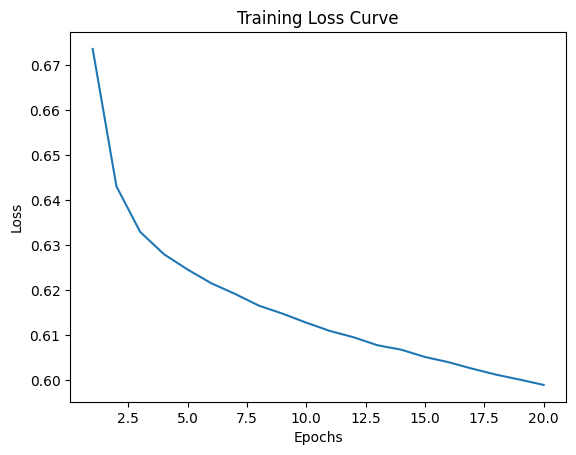

In [ ]:
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [ ]:
test(model, train_loader, test_loader, num_classes=output_size)


Confusion Matrix (Train):
[[9759 4224]
 [4800 8951]]

Classification Report (Train):
              precision    recall  f1-score   support

           0       0.67      0.70      0.68     13983
           1       0.68      0.65      0.66     13751

    accuracy                           0.67     27734
   macro avg       0.67      0.67      0.67     27734
weighted avg       0.67      0.67      0.67     27734


Confusion Matrix (Test):
[[4152 1947]
 [2051 3737]]

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.67      0.68      0.68      6099
           1       0.66      0.65      0.65      5788

    accuracy                           0.66     11887
   macro avg       0.66      0.66      0.66     11887
weighted avg       0.66      0.66      0.66     11887



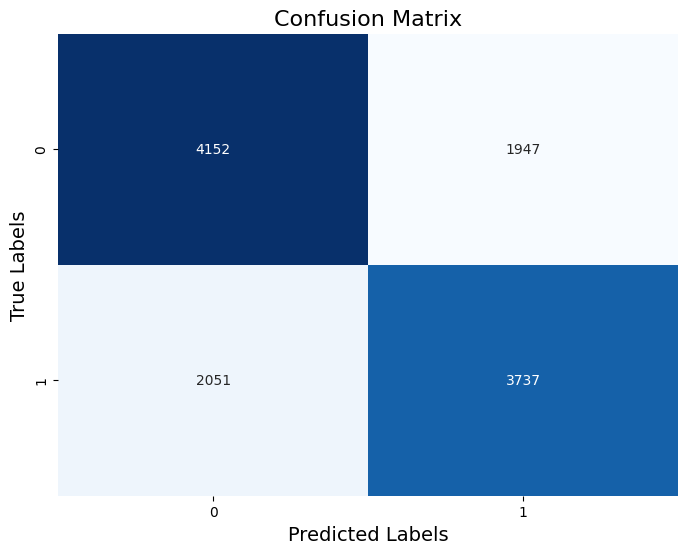

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, num_classes):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("True Labels", fontsize=14)
    plt.show()

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

plot_confusion_matrix(y_true, y_pred, num_classes=output_size)


In [ ]:

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

model.eval()
y_prob = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        y_prob.extend(probabilities[:, 1].numpy())
        y_true.extend(labels.numpy())


In [ ]:
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

print(f"AUC: {auc:.4f}")


AUC: 0.7271


<ipython-input-33-c33c5d436a2e>:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')  # Diagonal line


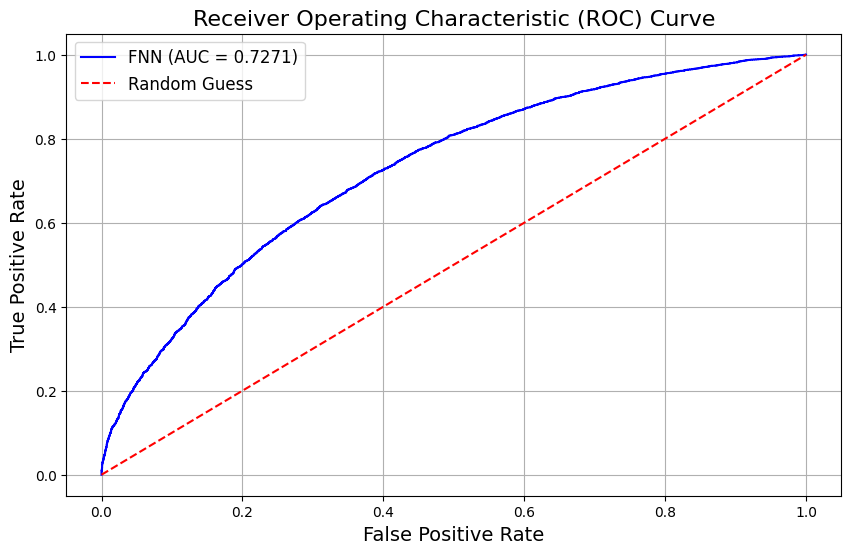

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'FNN (AUC = {auc:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


# CNN model

Epoch 1/20, Loss: 0.6371
Epoch 2/20, Loss: 0.6228
Epoch 3/20, Loss: 0.6169
Epoch 4/20, Loss: 0.6136
Epoch 5/20, Loss: 0.6083
Epoch 6/20, Loss: 0.6054
Epoch 7/20, Loss: 0.6026
Epoch 8/20, Loss: 0.5984
Epoch 9/20, Loss: 0.5936
Epoch 10/20, Loss: 0.5911
Epoch 11/20, Loss: 0.5869
Epoch 12/20, Loss: 0.5839
Epoch 13/20, Loss: 0.5759
Epoch 14/20, Loss: 0.5730
Epoch 15/20, Loss: 0.5673
Epoch 16/20, Loss: 0.5631
Epoch 17/20, Loss: 0.5569
Epoch 18/20, Loss: 0.5495
Epoch 19/20, Loss: 0.5446
Epoch 20/20, Loss: 0.5370


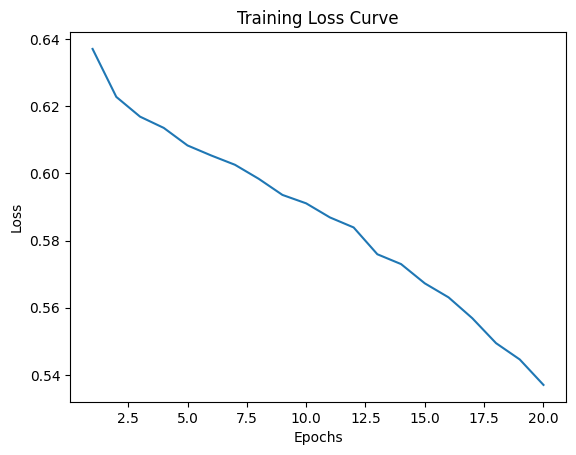


Confusion Matrix:


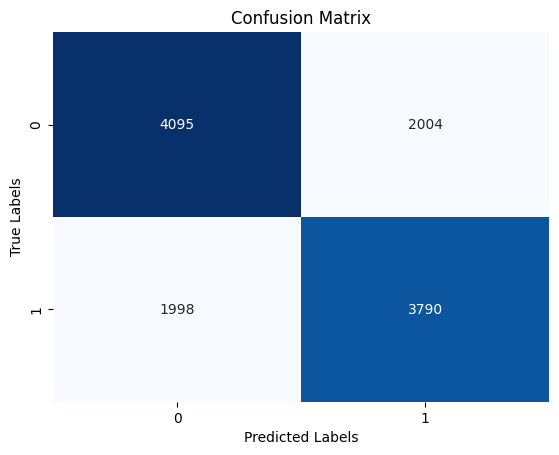


Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.67      0.67      6099
           1       0.65      0.65      0.65      5788

    accuracy                           0.66     11887
   macro avg       0.66      0.66      0.66     11887
weighted avg       0.66      0.66      0.66     11887

AUC: 0.7281


<ipython-input-4-17f2a3428246>:100: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')


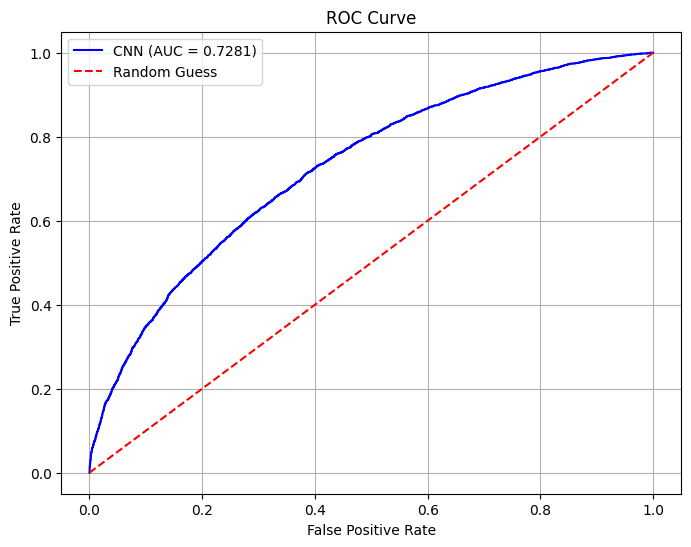

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score

class CNNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(input_size * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

torch.manual_seed(42)
model = CNNModel(input_size=X_train_tensor.shape[1], num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()

def training_loop(n_epochs, model, optimizer, loss_fn, train_loader):
    model.train()
    losses = []
    for epoch in range(n_epochs):
        total_loss = 0
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    return losses

n_epochs = 20
losses = training_loop(n_epochs, model, optimizer, loss_fn, train_loader)

plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

def evaluate_model(model, test_loader, num_classes):
    model.eval()
    y_pred, y_true, y_prob = [], [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
            y_prob.extend(probabilities[:, 1].tolist())

    print("\nConfusion Matrix:")
    conf_matrix = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=list(range(num_classes))))

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    print(f"AUC: {auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'CNN (AUC = {auc:.4f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess', color='red')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

evaluate_model(model, test_loader, num_classes=2)
